In [42]:
import sys
sys.path.append("../../")
import bandicoot as bc
import numpy as np
import pandas as pd
from datetime import datetime as dt
%matplotlib inline
import matplotlib.pylab as plt
import bandicoot_dev as bc_d
import bandicoot as bc
from build_dataset.workers import load_sensible_data as lsd
from build_dataset.workers import apply_time_constraints as atc

In [43]:
tc0 = {'hours': range(24), 'days': range(7), 'spans': [("06/01/14","24/01/14"), ("03/02/14","16/05/14"), ("01/09/14","05/12/14"), ("02/06/14","20/06/14")]}
tc1 = {'hours': range(24), 'days': range(7), 'spans': [("17/05/14","01/06/14"), ("06/12/14", "21/12/14")]}
tc2 = {'hours': range(24), 'days': range(7), 'spans': [("01/01/14","05/01/14"), ("25/01/14","02/02/14"), ("14/04/14","20/04/14"), ("21/06/14","30/08/14"), ("22/12/14", "31/12/14")]}

In [27]:
df_call = lsd.load(tc0['spans'], "calllog")
df_call = atc.apply(df_call, tc0)

df_sms = lsd.load(tc0['spans'], "sms")
df_sms = atc.apply(df_sms, tc0)

df_bt = lsd.load(tc0['spans'], "bluetooth")
df_bt = atc.apply(df_bt, tc0)

# filter bluetooth phone and distance (1.5 m)
is_phone = lambda x: (x & 0x001F00) == 0x000200
df_bt = df_bt[(is_phone(df_bt['class'])==True) & (df_bt['rssi'] > -75)]

<2014> jan feb mar apr may jun sep oct nov dec <2014> jan feb mar apr may jun sep oct nov dec <2014> jan feb mar apr may jun sep oct nov dec


In [40]:
df_screen = lsd.load(tc0['spans'], "screen")
df_screen = atc.apply(df_screen, tc0)

<2014> jan feb mar apr may jun sep oct nov dec


In [28]:
users = set(list(df_call['user'])) & set(list(df_sms['user']))

In [32]:
def _filter_call(df_u):
    df_u = df_u.drop('user', 1)
    df_u['interaction'] = "call"
    df_u['timestamp'] = [dt.fromtimestamp(t) for t in df_u['timestamp']/1000]
    df_u['type'] = ["in" if t == 1 else "out" for t in df_u['type']]
    df_u.columns = ["call_duration", "correspondent_id", "datetime", "direction", "interaction"]
    return df_u

def _filter_sms(df_u):
    df_u = df_u[df_u['status'] <= 0]
    df_u = df_u[df_u['type'] <= 2]
    df_u = df_u.drop(['status','user'], 1)
    df_u['interaction'] = 'text'
    df_u['timestamp'] = [dt.fromtimestamp(t) for t in df_u['timestamp']/1000]
    df_u['type'] = ["in" if t == 1 else "out" for t in df_u['type']]
    df_u['call_duration'] = ''
    df_u.columns = ["correspondent_id", "datetime", "direction", "interaction", "call_duration"]
    return df_u

def _filter_bt(u, df_u):
    df_u['interaction'] = 'physical'
    df_u['direction'] = ''
    df_u['timestamp'] = [dt.fromtimestamp(t) for t in df_u['timestamp']/1000]
    df_u['correspondent_id'] = [a if a != u else b 
                                for a,b in zip(df_u['bt_mac'].values, df_u['user'].values)]
    df_u['call_duration'] = ""
    df_u = df_u.drop(['class','id','bt_mac','rssi', 'user'], 1)
    df_u.columns = ["datetime", "interaction", "direction", "correspondent_id", "call_duration"]
    return df_u

for u in users:
    df_call_u = _filter_call(df_call[df_call['user'] == u])
    df_sms_u = _filter_sms(df_sms[df_sms['user'] == u])
    df_bt_u = _filter_bt(u, df_bt[(df_bt['user'] == u) | (df_bt['bt_mac'] == u)])
    
    df_u = pd.concat([df_sms_u, df_call_u, df_bt_u]).sort(['datetime'], ascending=1)
    df_u.to_csv("records/%d.csv" % u, index=False)
    
    if u%100==0:
        print u,
        
    break

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

0


/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:36: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [39]:
pd.set_option('max_rows',10000)
df_u

,call_duration,correspondent_id,datetime,direction,interaction
855692,,371,2014-01-06 07:53:32,,physical
52306,,-99905,2014-01-06 07:55:59,in,text
827307,,285,2014-01-06 08:38:41,,physical
868719,,371,2014-01-06 08:53:32,,physical
825012,,371,2014-01-06 08:54:52,,physical
868725,,371,2014-01-06 09:03:33,,physical
785061,,371,2014-01-06 09:13:38,,physical
11368,32,-96270,2014-01-06 09:23:36,out,call
785079,,285,2014-01-06 09:38:38,,physical
785082,,285,2014-01-06 09:43:39,,physical


In [36]:
B = bc_d.read_csv("0", "records/", network=True)

         interaction: 14063 record(s) with incomplete values
         direction: 14063 record(s) with incomplete values
         No antennas file was given and records are using antennas for position.
[x] 2867 records from 2014-01-06 07:55:59 to 2014-12-04 20:43:45
[x] 156 contacts
[ ] No attribute stored
[ ] No antenna stored
[x] Has home
[x] Has texts
[x] Has calls
[x] Has network


In [37]:
indicators_d = bc_d.utils.all(B, groupby="week", summary=None, dist=True, network=True, spatial=False)
#indicators = bc.utils.all(B, groupby="month", summary="default")

/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [7]:
meta = ['name', 'reporting']
good = ['active_days', 'number_of_contacts', 'call_duration',
        'percent_initiated_conversations', 'percent_initiated_interactions', 
        'response_delay_text', 'response_rate_text', 'entropy_of_contacts', 
        'interevent_time', 'percent_pareto_interactions', 'percent_pareto_durations', 
        'percent_interactions_out', 'percent_concluded_conversations', 'percent_overlap_conversations']
maybe = ['balance_of_contacts', 'number_of_interactions']
work = ['percent_nocturnal']
drop = ['interactions_per_contact']

for ex in meta:# + good + work + drop + maybe:
    del indicators_d[ex]

indicators_flat = bc_d.utils.flatten(indicators_d)

In [8]:
indicators_flat

OrderedDict([('active_days__allweek__allday__callandtext',
              [7,
               7,
               4,
               7,
               7,
               6,
               4,
               7,
               7,
               7,
               6,
               6,
               7,
               7,
               5,
               7,
               7,
               4,
               7,
               7,
               4,
               7,
               6,
               7,
               7,
               7,
               7,
               7,
               7,
               7,
               6,
               7,
               6,
               7,
               4]),
             ('number_of_contacts__allweek__allday__text',
              [9,
               6,
               8,
               5,
               10,
               8,
               6,
               11,
               10,
               14,
               8,
               9,
               8,
            

TypeError: len() of unsized object

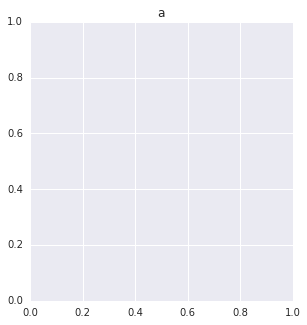

In [12]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
plt.figure(figsize=(16,6*len(indicators_flat)/3+1))
for i, indic in enumerate(indicators_flat):
    plt.subplot(len(indicators_flat)/3+1, 3, i+1)
    plt.title(indic[0])
    plt.hist(indic[1])
plt.show()